# Notebook to format data from "Extreme Diel Variation in the feeding behavior of humpback whales along the western Antarctic Peninsula during autumn", Friedlaender et al (2013).

Paper can be found [here](https://www.researchgate.net/publication/260209964_Extreme_diel_variation_in_the_feeding_behavior_of_humpback_whales_along_the_western_Antarctic_Peninsula_during_autumn).

Data was supplied by Ari Friedlaender directly, he agreed to have it posted publicly

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import scipy.io as sio

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/friedlaender_whales'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/friedlaender_whales'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
# features_fps = glob.glob(raw_data_dir + '/*.h5')
annotations_fps = glob.glob(raw_data_dir + '/annotations/*.csv')

# Currently missing this processed data file:
annotations_fps.remove('/home/jupyter/behavior_data_local/data/raw/friedlaender_whales/annotations/DiveInfo-mn09_122b.csv')

clip_ids = sorted([x.split('/')[-1].split('.')[0].split('-')[-1] for x in annotations_fps])
data_fps = [raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat' for clip_id in clip_ids]

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
for fp in data_fps:
    if not os.path.exists(fp):
        print(fp)
        
print('checked all data files exist!')

checked all data files exist!


In [6]:
# Dataset metadata
dataset_metadata = {}
sr = 5
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'friedlaender_whales'

In [7]:
## Integer codes for individuals

individual_ids = []
clip_id_to_individual_id = {}
for i, clip_id in enumerate(clip_ids):
    clip_id_to_individual_id[clip_id] = i
    individual_ids.append(i)

dataset_metadata['individual_ids'] = individual_ids
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id
dataset_metadata['clip_ids'] = clip_ids

individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

In [8]:
clip_id_to_individual_id

{'mn09_127a': 0,
 'mn09_148a': 1,
 'mn09_152a': 2,
 'mn10_132a': 3,
 'mn10_133a': 4,
 'mn10_139a': 5,
 'mn10_144a': 6,
 'mn10_151a': 7}

In [9]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual)
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [0, 5], 1: [1, 6], 2: [2, 7], 3: [3], 4: [4]}
There are 8 individuals


In [10]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

## Create dataset-level metadata

In [11]:
## Integer codes for specific behaviors

# list of behaviors (from metadata sent by Ari)
beh_names = ['unknown', 
             'rest', 
             'travel', 
             'exploratory', 
             'feed']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = annotations_fps[0]
individual_annotations = pd.read_csv(fp)
clip_id = fp.split('/')[-1].split('.')[0].split('-')[-1]
individual_annotations['clip_id'] = clip_id
individual_annotations['individual'] = clip_id_to_individual_id[clip_id]
all_annotations = individual_annotations

for fp in annotations_fps[1:]:
    individual_annotations = pd.read_csv(fp)
    clip_id = fp.split('/')[-1].split('.')[0].split('-')[-1]
    individual_annotations['clip_id'] = clip_id
    individual_annotations['individual'] = clip_id_to_individual_id[clip_id]
    all_annotations = all_annotations.append(individual_annotations)
    
all_annotations.reset_index(inplace = True)

all_annotations

,index,start_cue,end_cue,max_depth,cue_at_max_depth,mean_depth,mean_compression,dive_ID,Tdown,Tup,numLun,behav_state,clip_id,individual
0,0,11.6,199.0,52.298188,91.8,27.113664,0.328362,1,187.4,9.0,0,3,mn10_132a,3
1,1,208.0,264.0,6.705480,222.6,4.462636,0.705906,2,56.0,4.6,0,1,mn10_132a,3
2,2,268.6,293.4,3.403496,281.0,2.133435,0.831859,3,24.8,21.2,0,1,mn10_132a,3
3,3,314.6,422.2,8.240935,398.4,4.571292,0.699902,4,107.6,39.0,0,1,mn10_132a,3
4,4,461.2,614.8,10.256281,556.8,6.535076,0.619816,5,153.6,88.6,0,2,mn10_132a,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,185,85350.0,85498.8,10.947011,85432.2,5.557030,0.672250,186,148.8,465.4,0,2,mn09_127a,0
3423,186,85964.2,86371.0,65.303663,86124.0,29.227690,0.360925,187,406.8,275.6,0,3,mn09_127a,0
3424,187,86646.6,86879.4,22.524228,86796.0,14.454175,0.453717,188,232.8,2275.8,0,2,mn09_127a,0
3425,188,89155.2,89704.2,85.142815,89316.4,47.743034,0.228532,189,549.0,125.6,0,3,mn09_127a,0


In [12]:
# What are the observed labels?

all_annotations['behav_state'].value_counts()

4    1819
1     876
2     572
3     160
Name: behav_state, dtype: int64

In [13]:
## clip_data column names
## Use derivative of head to reflect change in direction

clip_column_names = ['AccX', 'AccY', 'AccZ', 'Depth', 'Speed', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [14]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [15]:
# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [16]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0
total_annotation_dur_samples = 0

for clip_id in clip_ids:
    # load features
    data_fp = raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat'
    data = sio.loadmat(data_fp)
    Aw = data['Aw']
    for i in range(3):
        Aw[:,i] = interpolate_nan(Aw[:, i])
    speed = data['speedJJ']
    speed = interpolate_nan(speed)
    depth = data['p']
    depth = interpolate_nan(depth)
    
    clip_dur_samples = np.shape(Aw)[0]
    total_dur_samples += clip_dur_samples
    
    # load annotations
    annotations_sub = all_annotations[all_annotations['clip_id'] == clip_id]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unkown"
    for i, row in annotations_sub.iterrows():
        int_label = row['behav_state']
        start_sample = int(row['start_cue']*sr)
        end_sample = int(row['end_cue'] * sr)
        per_frame_annotations[start_sample: end_sample, :] = int_label
        
    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([Aw, depth, speed, per_frame_individual_id, per_frame_annotations], axis = 1)
    clip_data = clip_data[:end_sample+1, :] # drop samples after last annotation to avoid artifacts
    
    clip_annotation_dur_samples = np.sum(per_frame_annotations > 0)
    total_annotation_dur_samples += clip_annotation_dur_samples
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    

/opt/conda/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [17]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 712412.200000 seconds, i.e. 197.892278 hours
total annotation duration is 410595.200000 seconds, i.e. 114.054222 hours


## Check it all looks ok

In [18]:
clip_id = clip_ids[7]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [19]:
np.shape(data)

(448491, 7)

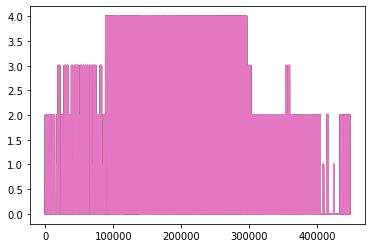

In [20]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, -1])

## Plot Dataset Summary

In [21]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]])


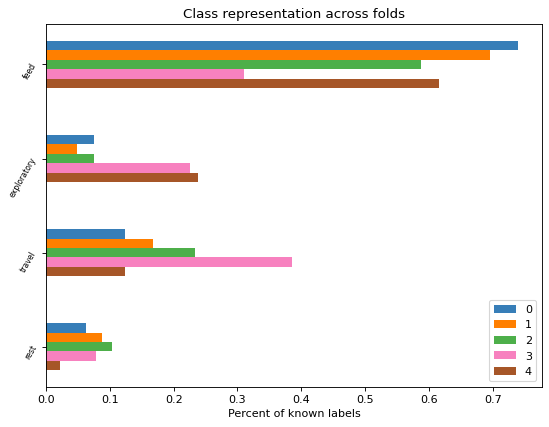

In [22]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

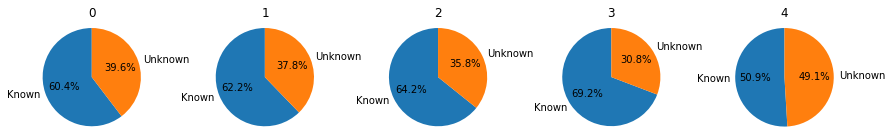

In [23]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()


## Temporal Statistics

In [24]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

Mean overall label duration is 119.812 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/friedlaender_whales/dataset_metadata.yaml
